In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [17]:
train_path = "data/train"
val_path = "data/val"

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))


# Load training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"  # For multi-class classification
)

# Load validation dataset
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

Found 18400 files belonging to 8 classes.
Found 2800 files belonging to 8 classes.


In [18]:
class_names = train_dataset.class_names
num_classes = len(class_names)

# Normalize the pixel values
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Print class names and number of classes
print(f"Class Names: {class_names}")
print(f"Number of Classes: {num_classes}")


Class Names: ['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']
Number of Classes: 8


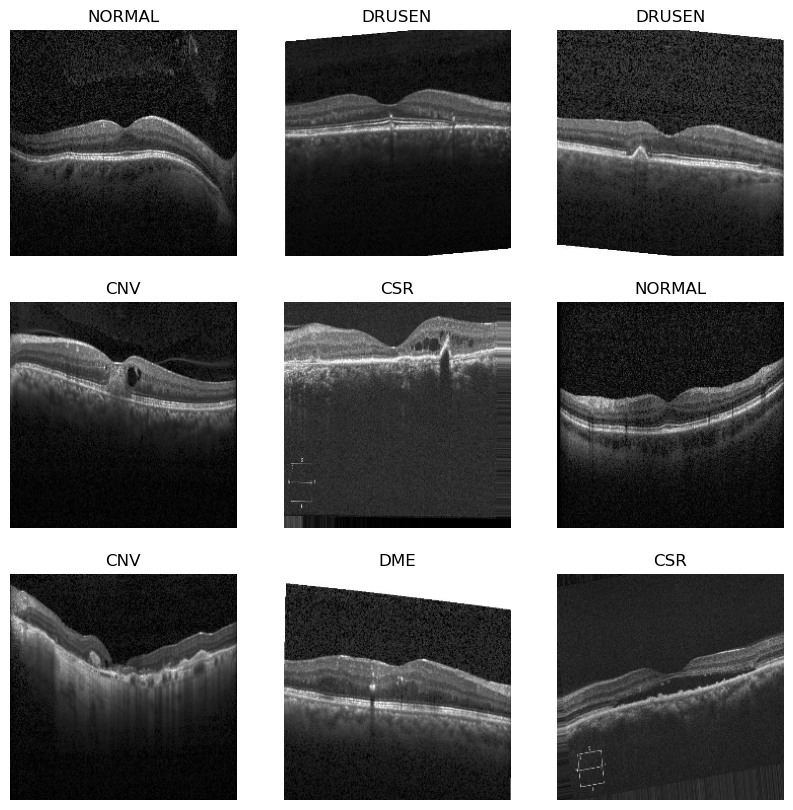

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
plt.show()

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),  # Dropout to prevent overfitting
    tf.keras.layers.Dense(num_classes, activation="softmax")
])


In [21]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [22]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10  # Adjust epochs as needed
)

Epoch 1/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 472s 818ms/step - accuracy: 0.4133 - loss: 1.3501 - val_accuracy: 0.5725 - val_loss: 0.9016
Epoch 2/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 1419s 2s/step - accuracy: 0.5999 - loss: 0.8901 - val_accuracy: 0.6921 - val_loss: 0.7170
Epoch 3/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 1018s 2s/step - accuracy: 0.7077 - loss: 0.6940 - val_accuracy: 0.7864 - val_loss: 0.5366
Epoch 4/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 41137s 72s/step - accuracy: 0.7997 - loss: 0.5061 - val_accuracy: 0.8486 - val_loss: 0.4121
Epoch 5/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 459s 799ms/step - accuracy: 0.8542 - loss: 0.3719 - val_accuracy: 0.8650 - val_loss: 0.3876
Epoch 6/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 490s 852ms/step - accuracy: 0.8961 - loss: 0.2656 - val_accuracy: 0.8736 - val_loss: 0.3698
Epoch 7/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 558s 970ms/step - accuracy: 0.9247 - loss: 0.2018 - val_accuracy: 0.8629 - val_loss: 0.4274
Epoch 8/10
575/575 ━━━━━━━━━━━━━━━━━━━━ 454s 789ms/step - accuracy: 0.9443 - los

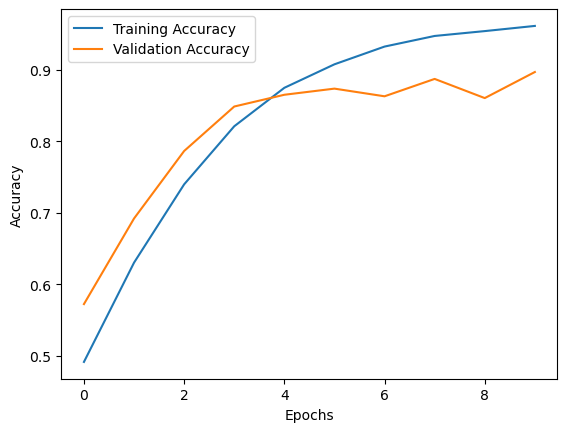

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
model.save("disease_detection_model.h5")
print("Model saved as 'disease_detection_model.h5'")


Model saved as 'disease_detection_model.h5'


In [25]:
loaded_model = tf.keras.models.load_model("disease_detection_model.h5")
print("Model loaded successfully")

# Test the model with a new image (optional)
from tensorflow.keras.preprocessing import image

# Path to test image
test_image_path = "data/test/DME/dme_test_1004.jpg"

# Load and preprocess the image
img = image.load_img(test_image_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]
print(f"Predicted Class: {predicted_class}")

Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Class: DME


In [26]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {test_accuracy:.2f}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.8973 - loss: 0.3908
Validation Accuracy: 0.90
